# Imports

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import xgboost

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier

In [17]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load data

In [6]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv")
y_train = pd.read_csv("../../data/processed/train_labels.csv")

In [7]:
X_train = X_train.iloc[:50000] # max 260601
y_train = y_train.iloc[:50000] # max 260601

# Import previously used functions

In [22]:
def compare_models_cv_acc_mcc(cv_results_list, model_names, n_samples, ylim, figsize, title) -> None:
    """
    Plot stacked bar charts to compare cross-validation results of different models. The plot will contain two subplots, one for accuracy and one for MCC. The plot will also contain horizontal guidelines for random guessing and the mean accuracy and MCC.

    :param cv_results_list: A list of dicts of float arrays of shape (n_splits,) that contain the cross-validation results of each model. Follows sklearn.model_selection.cross_validate() output format. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate for more details. Must contain the following keys: "test_accuracy", "test_matthews_corrcoef" in each dict list element. The length and order of the list must be equal to the length of model_names.
    :type cv_results_list: list
    :param model_names: A list of strings that represent the names of each model. The length and order of the list must be equal to the length of cv_results_list.
    :type model_names: list
    :param n_samples: The number of samples used in the cross-validation.
    :type n_samples: int
    :param ylim: The y-axis limits of the plot. Must be a tuple of two floats. The first float is the lower limit and the second float is the upper limit. The lower limit must be greater than or equal to 0. The upper limit must be less than or equal to 1.
    :type ylim: tuple
    :param figsize: The width and height of the plot in inches. Must be a tuple of two floats. The first float is the width and the second float is the height.
    :type figsize: tuple

    :return: None
    :rtype: None
    """

    # Check
    try:
        assert len(cv_results_list) == len(model_names)
    except AssertionError:
        print("cv_results_list and model_names must have the same length.")
        return

    # Create a figure
    fig, axes = plt.subplots(nrows=1, ncols=len(model_names), figsize=figsize)

    # Set palette
    palette = {
        "test_accuracy": sns.color_palette("Paired")[0],
        "test_matthews_corrcoef": sns.color_palette("Paired")[2]
    }

    # Plot each model
    for i, (cv_results, model_name) in enumerate(zip(cv_results_list, model_names)):
        # Create a dataframe
        df = pd.DataFrame(cv_results).reset_index(names='k-fold')
        df_melt = df[['k-fold', 'test_accuracy', 'test_matthews_corrcoef']].melt(id_vars=['k-fold'], var_name='Metric', value_name='Score')
        # Calculate mean and std
        agg = df_melt.groupby('Metric')['Score'].agg(['mean', 'std'])
        cv_mcc_mean = agg.loc["test_matthews_corrcoef"].at["mean"]
        cv_mcc_std = agg.loc["test_matthews_corrcoef"].at["std"]
        cv_acc_mean = agg.loc["test_accuracy"].at["mean"]
        cv_acc_std = agg.loc["test_accuracy"].at["std"]
        # Plot
        fig_ax = sns.barplot(x='k-fold', y='Score', hue='Metric', data=df_melt, ax=axes[i], dodge=False, errorbar=None, palette=palette)
        axes[i].set_title(f"Test Scoring {model_name}" + "\n" +
                          f"Mean MCC: {cv_mcc_mean:.3f} +/- {cv_mcc_std:.3f}, Mean Accuracy: {cv_acc_mean:.3f} +/- {cv_acc_std:.3f}")
        axes[i].legend().set_visible(False)
        # Add guidelines
        xmin, xmax = axes[i].get_xlim()
        axes[i].hlines(y=0.5, xmin=xmin, xmax=xmax, linestyles="dotted", colors='r', label="0.5")
        axes[i].hlines(y=cv_mcc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[3], label="Mean MCC")
        axes[i].hlines(y=cv_acc_mean, xmin=xmin, xmax=xmax, linestyles="dashed", colors=sns.color_palette("Paired")[1], label="Mean Accuracy")
        # Set y-axis limits
        plt.setp(axes[i], ylim=ylim)

    # Set legend
    handles, labels = axes[0].get_legend_handles_labels()
    order = [0, 2, 3, 1, 4]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    if title is None:
        title = f"Cross Validation Results ({n_samples} samples)"
    plt.suptitle(title, fontweight='bold')

    # Show plot
    plt.tight_layout()
    plt.show()

# Multiclass scenario
Option 1: **Classifiers supporting multiclass classification**, like Random Forest, XGBoost, CatBoost, etc. (already tested in the [notebooks of week 4](../week04)
Option 2: Ensemble of **binary classifiers with meta-strategies** like One-vs-all, One-vs-one, Output coding, etc.

**Explanation:** Most classifiers are limited to distinguishing between a handful of classes well (they will start to struggle when the number of classes becomes very high). Therefore, if you have a lot of classes, instead of training a single classifier for more than 2 classes, you can train multiple binary classifiers - which is easier for each classifier to learn. Then combine each of the classifiers’ binary outputs to generate multi-class outputs. For this purpose there are different kind of meta-strategies:

1. One-vs-all / One-vs-rest (OvA / OvR): One classifier per class (other classes forming the 2nd class)
2. One-vs-one (OvO): One classifier per pair of classes
3. Output coding: Encode class labels as binary number, one classifier per bit

Possible forward-looking downsides:
- A possible downside of this approach is that it requires one model to be created for each class. For example, three classes requires three models. This could be an issue for our large datasets (e.g. millions of rows) or slow models (e.g. neural networks) used.
- Another potential downside of this approach is that it requires the base models to be skillful. This is not a problem for some models, such as decision trees, but can be a problem for other models, such as logistic regression or neural networks. Which did not perform well in our case at all, as seen previously.



## 1. One-vs-all / One-vs-rest (OvA / OvR)
Reference: "Machine Learning: A Probabilistic Perspective" 2012 by Kevin P. Murphy, Chapter 8.3.1, p. 503

This approach is commonly used for algorithms that naturally predict numerical class membership probability or score, such as: Logistic Regression and Perceptron. Therefor these are tested using the implementation in scikit-learn.

### Logistic Regression

In [11]:
%%time
# define model
lr = LogisticRegression(multi_class='ovr',
                        random_state=42,
                        max_iter=1000,)
# cross validation
scores_lr = cross_validate(lr, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_lr['test_accuracy'].mean():.3f} +/- {scores_lr['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_lr['test_f1_macro'].mean():.3f} +/- {scores_lr['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_lr['test_matthews_corrcoef'].mean():.3f} +/- {scores_lr['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_lr['fit_time'].mean():.3f} +/- {scores_lr['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.567 +/- 0.000
F1 Macro: 0.241 +/- 0.000
MCC: 0.000 +/- 0.000
--------------------
With Runtime: 0.088 +/- 0.023
CPU times: total: 15.6 ms
Wall time: 1.14 s


### Perceptron

In [18]:
%%time
# define model
mlp = MLPClassifier(max_iter=200,
                    random_state=42)

# cross validation
scores_mlp = cross_validate(mlp, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_mlp['test_accuracy'].mean():.3f} +/- {scores_mlp['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_mlp['test_f1_macro'].mean():.3f} +/- {scores_mlp['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_mlp['test_matthews_corrcoef'].mean():.3f} +/- {scores_mlp['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_mlp['fit_time'].mean():.3f} +/- {scores_mlp['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.384 +/- 0.092
F1 Macro: 0.185 +/- 0.029
MCC: 0.012 +/- 0.010
--------------------
With Runtime: 3.052 +/- 0.516
CPU times: total: 62.5 ms
Wall time: 6.76 s


### Base Model XGBoost for Comparison

In [ ]:
# encode for xgb
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train['damage_grade'])

In [14]:
%%time
# define model
xgb = xgboost.XGBClassifier(n_estimators=100,
                            max_depth=20,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            random_state=42,
                            n_jobs=-1)

# define the ovr strategy
ovr = OneVsRestClassifier(xgb)

# cross validation
scores_xgb = cross_validate(ovr, X_train, y_train['damage_grade'], cv=5, scoring=['accuracy', 'f1_macro', 'matthews_corrcoef'], n_jobs=-1)

# print results
print(f"Accuracy: {scores_xgb['test_accuracy'].mean():.3f} +/- {scores_xgb['test_accuracy'].std():.3f}")
print(f"F1 Macro: {scores_xgb['test_f1_macro'].mean():.3f} +/- {scores_xgb['test_f1_macro'].std():.3f}")
print(f"MCC: {scores_xgb['test_matthews_corrcoef'].mean():.3f} +/- {scores_xgb['test_matthews_corrcoef'].std():.3f}")
print('-'*20)
print(f"With Runtime: {scores_xgb['fit_time'].mean():.3f} +/- {scores_xgb['fit_time'].std():.3f}")
print('='*20)

Accuracy: 0.712 +/- 0.004
F1 Macro: 0.642 +/- 0.006
MCC: 0.459 +/- 0.008
--------------------
With Runtime: 62.735 +/- 0.566
CPU times: total: 31.2 ms
Wall time: 1min 7s


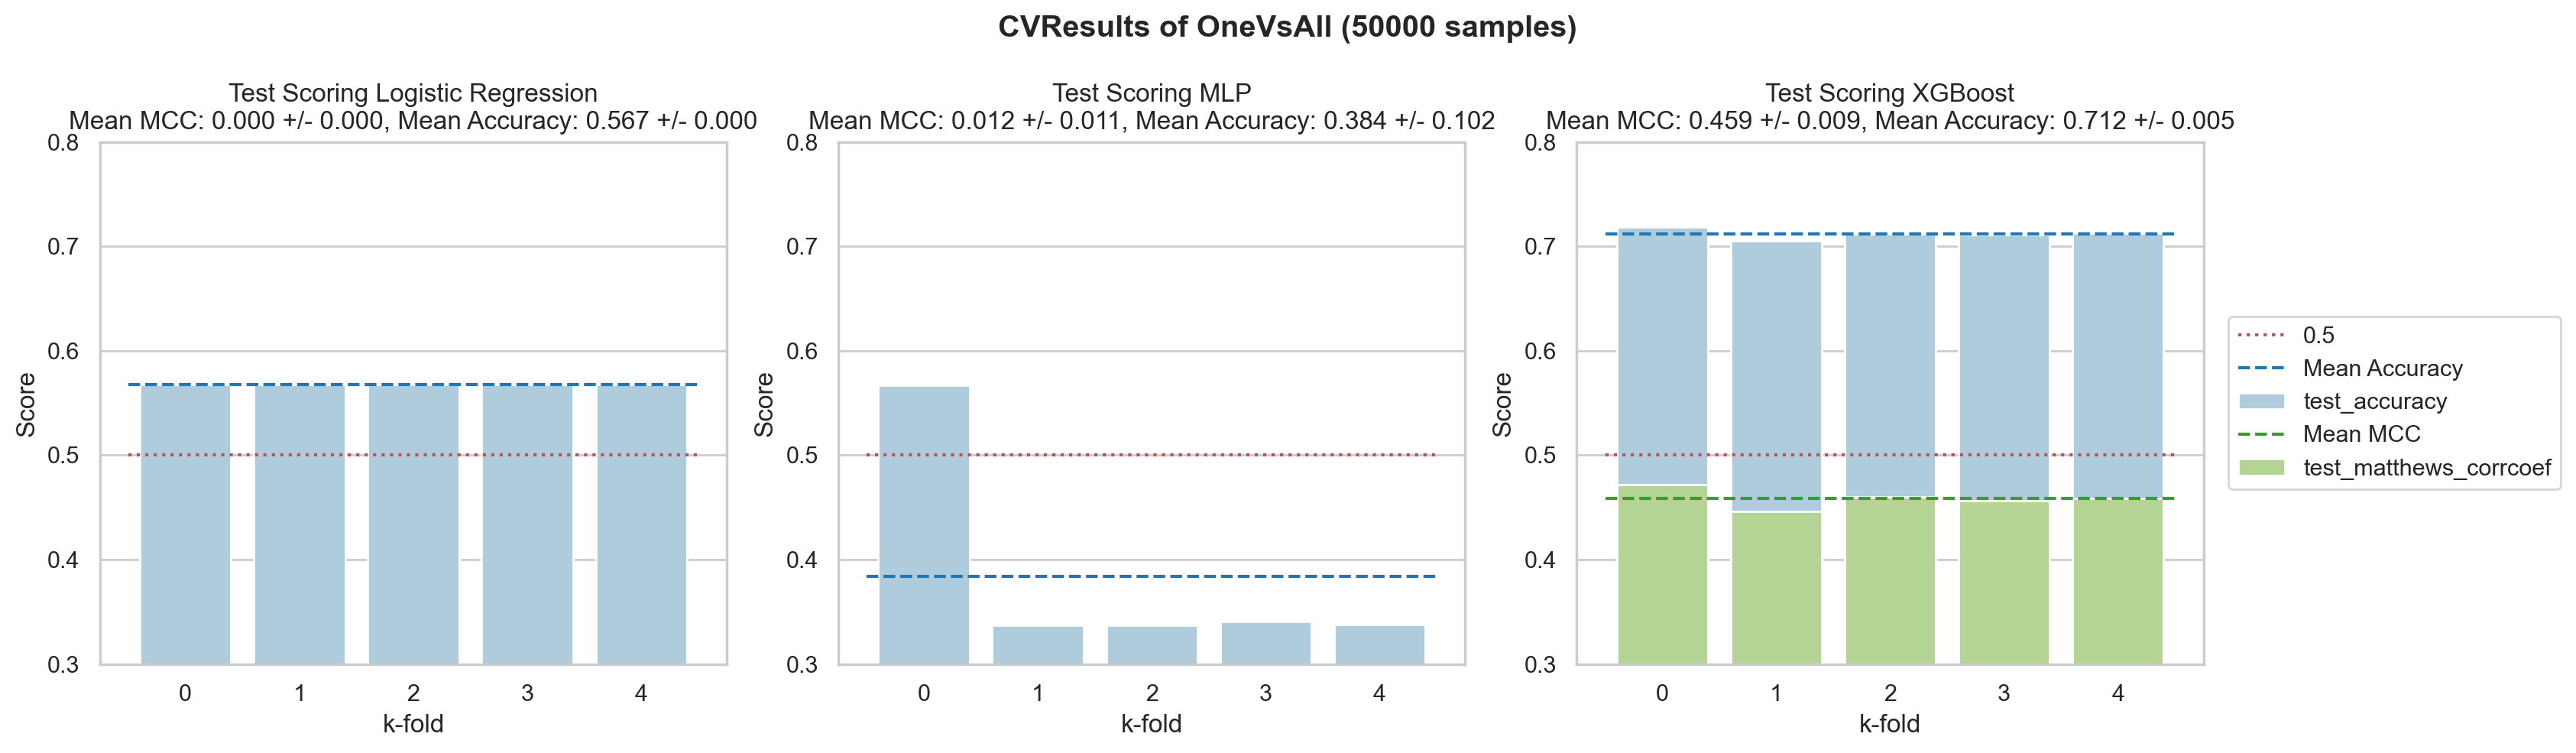

In [23]:
# compare models using meta-strategy OvA
compare_models_cv_acc_mcc([scores_lr, scores_mlp, scores_xgb], ['Logistic Regression', 'MLP', 'XGBoost'], 50000, (0.3, 0.8), (17, 5), f"CVResults of OneVsAll ({50000} samples)")

## 2. One-vs-one (OvO)
Reference: "Pattern Recognition and Machine Learning" 2006 by Christopher M. Bishop, p.183

Like one-vs-rest, one-vs-one splits a multi-class classification dataset into binary classification problems. Unlike one-vs-rest that splits it into one binary dataset for each class, the one-vs-one approach splits the dataset into one dataset for each class versus every other class. This approach is suitable for algorithms that do not naturally predict a probability or score for each class, such as: Support Vector Machine and k-Nearest Neighbors. Therefor these are tested using the implementation in scikit-learn.